<a href="https://colab.research.google.com/github/ketan9808/Emotion_Detection/blob/master/Emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!rm /content/sample_data/*
!rmdir /content/sample_data

In [2]:
# Everytime you will revisit the notebook after closing the session you have to upload the kaggle.json
# in case you restart the runtime you don't need to re-upload the kaggle .json
# nither the files that you have downloaded
from google.colab import files

files.upload() #prompt to upload kaggle.json
!mkdir /root/.kaggle #Creating a directory to store kaggle.json
!mv /content/kaggle.json /root/.kaggle/kaggle.json #moving kaggle.json to /root/.kaggle directory
!ls /root/.kaggle -a #Listing the content of the /root/.kaggle directory
!chmod 600 /root/.kaggle/kaggle.json #Changing property of file so that only i can see the key

Saving kaggle.json to kaggle.json
.  ..  kaggle.json


In [3]:
# The try except block is used to select tf2.x version
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import kaggle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

print(tf.__version__)

2.2.0-rc1


In [4]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 12.8MB/s]
 47% 9.00M/19.3M [00:00<00:00, 17.7MB/s]
100% 19.3M/19.3M [00:00<00:00, 30.4MB/s]
 86% 83.0M/96.6M [00:01<00:00, 51.7MB/s]
100% 96.6M/96.6M [00:01<00:00, 68.6MB/s]
 89% 69.0M/77.3M [00:01<00:00, 45.6MB/s]
100% 77.3M/77.3M [00:01<00:00, 65.6MB/s]
 84% 77.0M/92.0M [00:02<00:00, 19.6MB/s]
100% 92.0M/92.0M [00:02<00:00, 45.5MB/s]


In [5]:
# !unzip icml_face_data.csv.zipz
!unzip train.csv.zip
# !unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


# Data Exploration and Preprocessing
some important points
- 48X48 grayscals images
- Emotions : 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
- train.csv has 2 col. emotion and pixels
  - emotion [0-6]
  - pixel string containging pixel value ( space-separated pixel value in row major order)
- test.csv has only pixel column and we have to predict the emotion


- train set has 28709 example
- public test 3589 examples
- private test 3589 examples
- icml has 35887 examples

In [0]:
emotion = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [7]:
train = pd.read_csv("train.csv")
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [8]:
happy_series = train[train.emotion == 3].pixels
happy_labels = [[1, 0, 0] for i in range(len(happy_series))]

sad_series = train[train.emotion == 4].pixels
sad_labels = [[0, 1, 0] for i in range(len(sad_series))]

neutral_series = train[train.emotion == 6].pixels
neutral_labels = [[0, 0, 1] for i in range(len(neutral_series))]

print(len(happy_series), len(happy_labels), len(sad_series), len(sad_labels), len(neutral_series), len(neutral_labels), sep = '\n')

7215
7215
4830
4830
4965
4965


In [0]:
def convert_image(df):
  temp = []
  label = []
  for index, emotion_class in enumerate(df):
    for i in emotion_class:
      arr = [int(j) for j in i.split()]
      arr = np.array(arr, dtype = np.uint8)
      arr = arr.reshape(48, 48)
      arr = np.expand_dims(arr, -1)
      temp.append(arr)
      class_label = [0, 0, 0]
      class_label[index] = 1
      label.append(class_label)
  return temp, label

In [10]:
data, labels = convert_image([happy_series, sad_series, neutral_series])
data = np.array(data, dtype = np.uint8)
labels = np.array(labels)
print(data.shape,labels.shape)

total_train = int(data.shape[0]*0.8)
total_val = int(data.shape[0]*0.2)

(17010, 48, 48, 1) (17010, 3)


In [0]:
BATCH_SIZE = 512
EPOCHS = 1000
IMG_HEIGHT = 48
IMG_WIDTH = 48

In [0]:
train_image_generator = ImageDataGenerator(
                                  validation_split = 0.2,
                                  rescale = 1./255,
                                  vertical_flip=True,
                                  rotation_range=45,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  fill_mode='reflect'
                                  )

In [0]:
train_data_gen = train_image_generator.flow(x = data,
                                            y = labels,
                                            shuffle=True,
                                            batch_size = BATCH_SIZE,
                                            subset = 'training')
validation_data_gen = train_image_generator.flow(x = data,
                                                 y = labels,
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE,
                                                 subset='validation')

In [14]:
sample_training_image , sample_training_label = next(train_data_gen)
sample_training_image.shape

(512, 48, 48, 1)

In [0]:
def plot_images(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (20, 20))
  axes = axes.flatten()
  for image, axis in zip(images_arr, axes):
    axis.imshow(image)
    axis.axis("off")
  plt.tight_layout()
  plt.show()

In [0]:
# plot_images(sample_training_image[:5])

# Create your own model
I will try the following
- Create a baseline Neural Network model
- Create a baseline Convolution Neural Network model
- Create a Transfer Learning model
  - Without fine tuning
  - With fine tuning
- Create a model with equal number of examples from each class

and then tune these models to get better accuracy

In [0]:
model = Sequential([
                    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH,1)),
                    MaxPooling2D(),
                    Dropout(0.5),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.5),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.5),
                    Flatten(),
                    Dropout(0.3),
                    Dense(256, activation='relu'),
                    Dropout(0.3),
                    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(train_data_gen, 
                  steps_per_epoch=(total_train*0.8)//BATCH_SIZE,
                  epochs = EPOCHS,
                  validation_data = validation_data_gen,
                  validation_steps= (total_train*0.2)//BATCH_SIZE
                  )

Epoch 1/1000
21/21 [==============================] - 4s 200ms/step - loss: 1.0456 - accuracy: 0.4498 - val_loss: 1.2120 - val_accuracy: 0.2881
Epoch 2/1000
21/21 [==============================] - 4s 206ms/step - loss: 1.0457 - accuracy: 0.4419 - val_loss: 1.2702 - val_accuracy: 0.2237
Epoch 3/1000
21/21 [==============================] - 4s 206ms/step - loss: 1.0417 - accuracy: 0.4519 - val_loss: 1.1956 - val_accuracy: 0.3309
Epoch 4/1000
21/21 [==============================] - 4s 209ms/step - loss: 1.0460 - accuracy: 0.4456 - val_loss: 1.1643 - val_accuracy: 0.3598
Epoch 5/1000
21/21 [==============================] - 4s 206ms/step - loss: 1.0483 - accuracy: 0.4452 - val_loss: 1.2460 - val_accuracy: 0.2855
Epoch 6/1000
21/21 [==============================] - 4s 199ms/step - loss: 1.0473 - accuracy: 0.4443 - val_loss: 1.2569 - val_accuracy: 0.2275
Epoch 7/1000
21/21 [==============================] - 4s 209ms/step - loss: 1.0468 - accuracy: 0.4516 - val_loss: 1.1106 - val_accuracy:

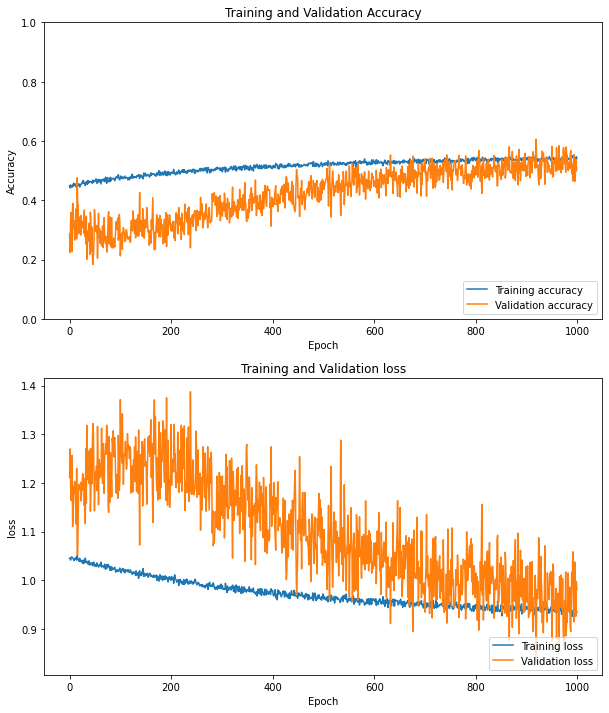

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10,12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title("Training and Validation loss")
plt.show()